In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

from src.utils import generate_style_dict, KStyledMNIST, KStyledMNISTGenerator

In [4]:
np.random.seed(101)
torch.manual_seed(101)
mnist = torchvision.datasets.MNIST(
    "../data", train=True, download=True
)

style_fns = [
    corruptions.identity,
    corruptions.stripe,
    corruptions.zigzag,
    lambda x: corruptions.scale(x, 5),
    corruptions.brightness,
]

In [5]:
def get_data_splits(k: int, seed: int, style_fns=style_fns):
    """
    Generate data splits and style dictionaries for k styled MNIST dataset

    Parameters:
        k (int): The number of styles to generate for each class
        seed (int): The random seed for reproducibility

    Returns:
        style_dict (dict): A dictionary containing the style information for each class
        train (k styled MNIST)
        valid (k styled MNIST)
        test (m-k styled MNIST)
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    mnist = torchvision.datasets.MNIST("../data", train=True)
    mnist_train, mnist_test = random_split(mnist, [50000, 10000])
    style_dict = generate_style_dict(classes=list(range(10)), style_fns=style_fns, k=k)
    mnist_generator = KStyledMNISTGenerator(mnist_train, style_dict, "train", style_fns)
    train = KStyledMNIST(
        mnist_generator,
        transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
    )
    mnist_generator = KStyledMNISTGenerator(mnist_test, style_dict, "test", style_fns)
    test = KStyledMNIST(
        mnist_generator,
        transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
    )
    train_size = int(0.85 * len(train))
    train, valid = random_split(train, [train_size, len(train) - train_size])
    return style_dict, train, valid, test

In [6]:
style_dict, train, valid, test = get_data_splits(k=2, seed=101)

Generating dataset: 100%|██████████| 10000/10000 [00:01<00:00, 5511.61item/s]


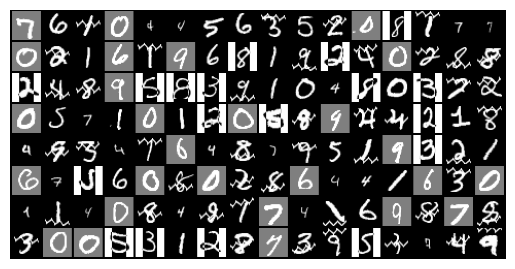

In [7]:
X, label, _ = next(iter(DataLoader(train, batch_size=128, shuffle=True)))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()

In [8]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [9]:
from ps_src import MLPTrainer

### with ps

In [10]:
mlp = nn.Sequential(
    nn.Linear(784, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 2),
).to(device)
cls_head = nn.Linear(2, 10).to(device)
optimizer = torch.optim.Adam(
    list(mlp.parameters()) + list(cls_head.parameters()), lr=1e-3
)
criterion = nn.CrossEntropyLoss()
trainer = MLPTrainer(mlp, cls_head, optimizer, criterion, verbose_period=5, device=device, pair_switch=True)
trainer.fit(
    epochs=41,
    train_loader=train_loader,
    valid_loader=valid_loader,
)

val-epoch 0: 100%|██████████| 59/59 [00:00<00:00, 589.03it/s]


val_acc: 0.158


val-epoch 5: 100%|██████████| 59/59 [00:00<00:00, 428.80it/s]


val_acc: 0.261


val-epoch 10: 100%|██████████| 59/59 [00:00<00:00, 383.34it/s]


val_acc: 0.301


val-epoch 15: 100%|██████████| 59/59 [00:00<00:00, 463.96it/s]


val_acc: 0.334


val-epoch 20: 100%|██████████| 59/59 [00:00<00:00, 422.40it/s]


val_acc: 0.351


val-epoch 25: 100%|██████████| 59/59 [00:00<00:00, 427.06it/s]


val_acc: 0.357


val-epoch 30: 100%|██████████| 59/59 [00:00<00:00, 416.44it/s]


val_acc: 0.377


val-epoch 35: 100%|██████████| 59/59 [00:00<00:00, 456.92it/s]


val_acc: 0.381


val-epoch 40: 100%|██████████| 59/59 [00:00<00:00, 422.32it/s]

val_acc: 0.393


In [11]:
(aupr_score, auroc_score), acc = trainer.evaluate(
    test_loader, False, 0
)
print(f"test_acc: {round(float(acc), 3)}")
print(f"test_aupr: {aupr_score}")
print(f"test_auroc: {auroc_score}")

test_acc: 0.283
test_aupr: {0: 0.237, 1: 0.334, 2: 0.351, 3: 0.313, 4: 0.297, 5: 0.121, 6: 0.315, 7: 0.141, 8: 0.19, 9: 0.327}
test_auroc: {0: 0.534, 1: 0.867, 2: 0.805, 3: 0.732, 4: 0.815, 5: 0.627, 6: 0.751, 7: 0.627, 8: 0.712, 9: 0.767}


In [12]:
hs = []
outcome_labels = []
style_labels = []
for batch in test_loader:
    X_batch, y_batch, label_batch = (
        batch[0].view(-1, 784).to(device),
        batch[1].view(-1).long().to(device),
        batch[-1].view(-1).long().to(device),
    )
    h = mlp(X_batch)
    hs.append(h)
    style_labels.append(label_batch)
    outcome_labels.append(y_batch)
hs, outcome_labels, style_labels = (
    torch.cat(hs),
    torch.cat(outcome_labels),
    torch.cat(style_labels),
)
hs = hs.detach().cpu().numpy()
outcome_labels = outcome_labels.cpu().numpy()
style_labels = style_labels.cpu().numpy()

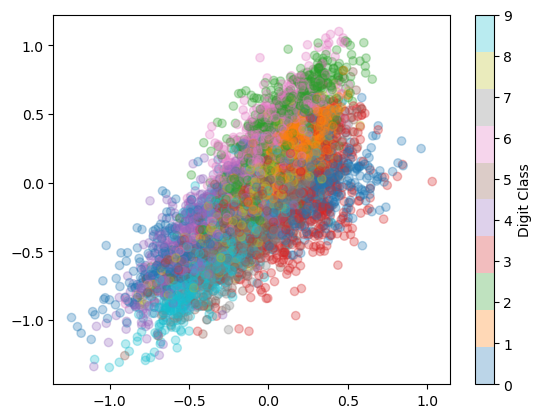

In [13]:
plt.scatter(hs[:, 0], hs[:, 1], alpha=0.3, 
            c=outcome_labels, cmap='tab10')
plt.colorbar(label='Digit Class')

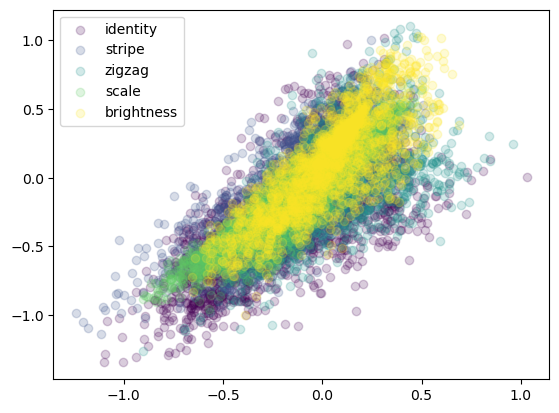

In [14]:
styles = ['identity', 'stripe', 'zigzag', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(styles))]

fig, ax = plt.subplots()
for g in range(len(styles)):
    i = np.where(style_labels == g)[0]
    ax.scatter(hs[i,0], hs[i,1], alpha=0.2, 
               c=colors[g], label=styles[g])
ax.legend()
plt.show()

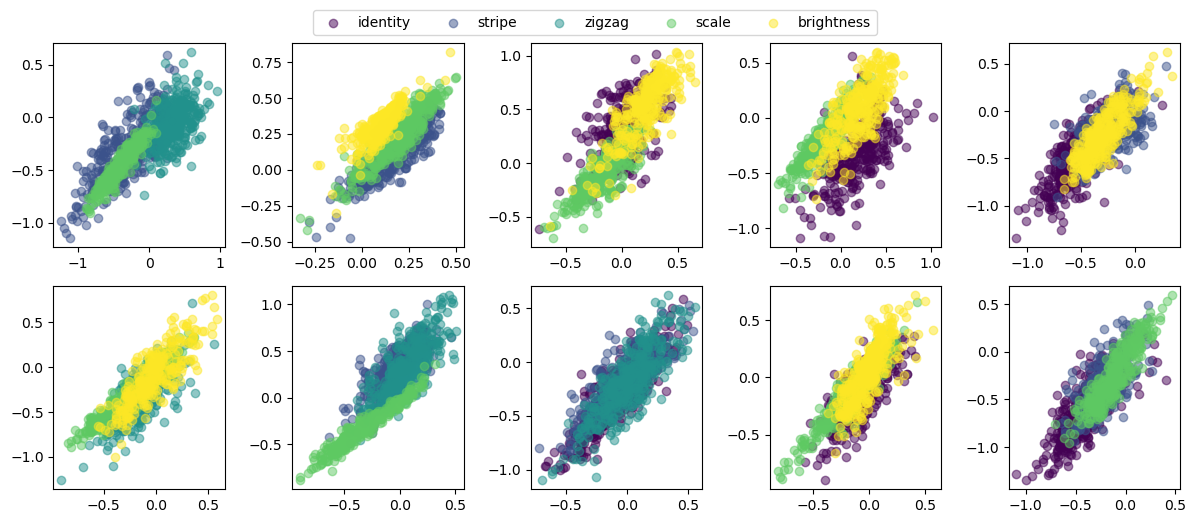

In [15]:
styles = ['identity', 'stripe', 'zigzag', 'scale', 'brightness']
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(styles))]

fig, axs = plt.subplots(2, 5, figsize=(12, 5))
handles = []  # To collect handles for the legend
labels = []   # To collect labels for the legend

for i, ax in enumerate(axs.flat):
    cond = np.where(outcome_labels == i)[0]
    for g in range(len(styles)):
        inds = np.where(style_labels[cond] == g)[0]
        scatter = ax.scatter(
            hs[cond[inds], 0], hs[cond[inds], 1], 
            alpha=0.5, c=[colors[g]], label=styles[g]
        )
        if styles[g] not in labels:  # Avoid duplicate labels in the legend
            handles.append(scatter)
            labels.append(styles[g])

# Add a single legend outside the subplots
fig.legend(handles, labels, loc='upper center', ncol=len(styles), bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()
plt.show()

### without ps

In [16]:
mlp = nn.Sequential(
    nn.Linear(784, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 2),
).to(device)
cls_head = nn.Linear(2, 10).to(device)
optimizer = torch.optim.Adam(
    list(mlp.parameters()) + list(cls_head.parameters()), lr=1e-3
)
criterion = nn.CrossEntropyLoss()
trainer = MLPTrainer(mlp, cls_head, optimizer, criterion, verbose_period=5, device=device, pair_switch=False)
trainer.fit(
    epochs=41,
    train_loader=train_loader,
    valid_loader=valid_loader,
)

val-epoch 0: 100%|██████████| 59/59 [00:00<00:00, 395.05it/s]


val_acc: 0.647


val-epoch 5: 100%|██████████| 59/59 [00:00<00:00, 392.48it/s]


val_acc: 0.862


val-epoch 10: 100%|██████████| 59/59 [00:00<00:00, 435.03it/s]


val_acc: 0.843


val-epoch 15: 100%|██████████| 59/59 [00:00<00:00, 388.50it/s]


val_acc: 0.912


val-epoch 20: 100%|██████████| 59/59 [00:00<00:00, 416.67it/s]


val_acc: 0.923


val-epoch 25: 100%|██████████| 59/59 [00:00<00:00, 442.34it/s]


val_acc: 0.92


val-epoch 30: 100%|██████████| 59/59 [00:00<00:00, 418.20it/s]


val_acc: 0.908


val-epoch 35: 100%|██████████| 59/59 [00:00<00:00, 420.24it/s]


val_acc: 0.918


val-epoch 40: 100%|██████████| 59/59 [00:00<00:00, 386.89it/s]


val_acc: 0.922


In [17]:
(aupr_score, auroc_score), acc = trainer.evaluate(
    test_loader, False, 0
)
print(f"test_acc: {round(float(acc), 3)}")
print(f"test_aupr: {aupr_score}")
print(f"test_auroc: {auroc_score}")

test_acc: 0.267
test_aupr: {0: 0.263, 1: 0.215, 2: 0.321, 3: 0.322, 4: 0.41, 5: 0.209, 6: 0.422, 7: 0.164, 8: 0.169, 9: 0.339}
test_auroc: {0: 0.666, 1: 0.731, 2: 0.727, 3: 0.623, 4: 0.764, 5: 0.672, 6: 0.8, 7: 0.519, 8: 0.594, 9: 0.763}


In [18]:
hs = []
outcome_labels = []
style_labels = []
for batch in test_loader:
    X_batch, y_batch, label_batch = (
        batch[0].view(-1, 784).to(device),
        batch[1].view(-1).long().to(device),
        batch[-1].view(-1).long().to(device),
    )
    h = mlp(X_batch)
    hs.append(h)
    style_labels.append(label_batch)
    outcome_labels.append(y_batch)
hs, outcome_labels, style_labels = (
    torch.cat(hs),
    torch.cat(outcome_labels),
    torch.cat(style_labels),
)
hs = hs.detach().cpu().numpy()
outcome_labels = outcome_labels.cpu().numpy()
style_labels = style_labels.cpu().numpy()

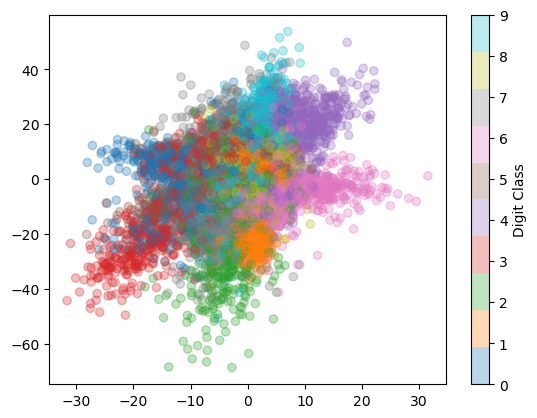

In [19]:
plt.scatter(hs[:, 0], hs[:, 1], alpha=0.3, 
            c=outcome_labels, cmap='tab10')
plt.colorbar(label='Digit Class')

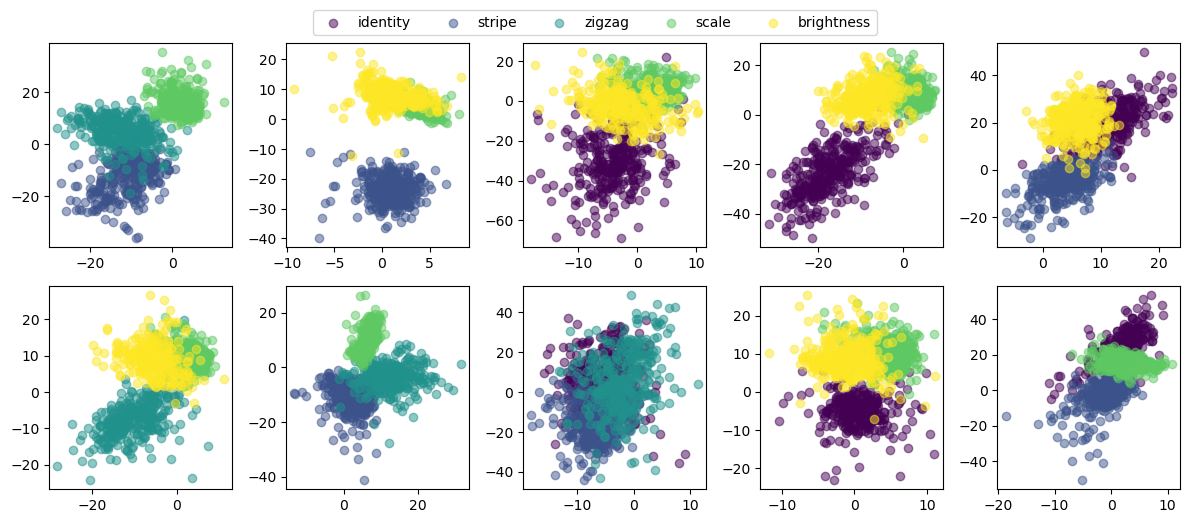

In [20]:
styles = ['identity', 'stripe', 'zigzag', 'scale', 'brightness']
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(styles))]

fig, axs = plt.subplots(2, 5, figsize=(12, 5))
handles = []  # To collect handles for the legend
labels = []   # To collect labels for the legend

for i, ax in enumerate(axs.flat):
    cond = np.where(outcome_labels == i)[0]
    for g in range(len(styles)):
        inds = np.where(style_labels[cond] == g)[0]
        scatter = ax.scatter(
            hs[cond[inds], 0], hs[cond[inds], 1], 
            alpha=0.5, c=[colors[g]], label=styles[g]
        )
        if styles[g] not in labels:  # Avoid duplicate labels in the legend
            handles.append(scatter)
            labels.append(styles[g])

# Add a single legend outside the subplots
fig.legend(handles, labels, loc='upper center', ncol=len(styles), bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()
plt.show()